# Portfolio analysis
This notebook introduces the concept of portfolio-level analyses. In this notebook, the results of the asset-level analysis are translated into firm-level results which are subsequently translated into portfolio-level results.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import poisson

from prisk.utils import extract_firms, link_basins
from prisk.kernel import Kernel
from prisk.cyclone import CycloneEntitySim, CycloneBasinSim
from prisk.portfolio import Portfolio
from prisk.insurance import Insurance

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
flood_protection = 100
insured = False
insurer_capital = 2e9
simulations = 1000
country = "India"
random_seed = 0

In [3]:
power = pd.read_excel("power.xlsx")
hybas_basins = "India_District_02_HP.shp"
grid_outlet_file = "india_0.1deg_grid.csv"

The files containing the randomly generated samples can be generated using the notebooks found in the Exploratory analysis folder. Alternatively, they can be downloaded from the link in the package README.md file.

In [ ]:
gaussian_random_numbers = pd.read_parquet("../Data/gaussian_random_numbers_cooccurrence_india.parquet.gzip")
t_random_numbers = pd.read_parquet("../Data/t_random_numbers_cooccurrence_india.parquet.gzip")
vine_random_numbers = pd.read_parquet("../Data/vine_random_numbers_cooccurrence_india.parquet.gzip")
uniform_random_numbers = pd.read_parquet("../Data/uniform_random_numbers_india.parquet.gzip")
complete_dependent_random_numbers = pd.read_parquet("../Data/complete_dependent_random_numbers_india.parquet.gzip")

##### Extracting Agents
The P-RISK model is based on asset-level analyses that are subsequently translated into firm- and portfolio-level impacts. To extract the firms from the Global Energy Monitor database, we use a utility function. If this approach is applied on a different dataset, then the extract_firms function needs to be replaced. We assume flood protection levels (consistent with other literature).

We limit the analysis to a single country.

In [4]:
india = power[power["Country"] == country].copy().reset_index(drop=True).drop(columns=[2])
firms = extract_firms(india)

##### Portfolio construction
The portfolio consists of the firms linked to the assets located in India(?). We assume an equal weighted portfolio:

In [5]:
portfolio = Portfolio("India power assets")
nav = 1
for firm in firms:
    portfolio.add_position(firm, nav/(len(firms)*firm.npv))                    

## Conduct simulation
The prisk simulations are still performed at the asset-level but due to the set-up with python classes, the results can easily be analysed at the portfolio-level. In each notebook, we perform multiple versions of the prisk framework that differentiate in the dependency modelling framework that was used. The five frameworks are:
1. **Completely independent events**: each asset has independent flood events that occur.
2. **Basin-level dependence**: floods are simulated at the basin-level. Whenever a flood occurs in a basin, all assets located inside that basin are affected. The floods between basins are assumed to be independent.
3. **Complete dependence**: the dependency of floods between basins are modelled using three copula functions: (1) gaussian copula, (2) the t-copula, and (3) the vine copula.

At the beginning of each of the model cells, we set the random seed. This ensures that the results are (1) completely reproducible, (2) perfectly compareable across different notebook versions (robustness checks), and (3) perfectly comparable across different dependency modelling approaches.

#### 1. Complete independence

In [6]:
np.random.seed(0)

portfolio_values = []
for i in tqdm(range(simulations)):
    assets = india.asset.to_list().copy()
    insurer = Insurance("Insurance company", capital=insurer_capital, subscribers=[])
    kernel = Kernel(assets=assets, insurers=[insurer])
    for asset in assets:
        if insured:
            asset.add_insurer(insurer)
        # The cyclone entity sim simulates floods at the asset-level without considering other asset events
        CycloneEntitySim(asset).simulate(time_horizon=25, kernel=kernel)
    kernel.run(time_horizon=25, verbose=0) # time horizon: 25 years, the remainder will be included in TV
    portfolio_values.append(portfolio.underlying_value)
    for asset in assets:
        asset.reset() # Reset the assets to their initial state

100%|██████████| 1000/1000 [04:42<00:00,  3.54it/s]


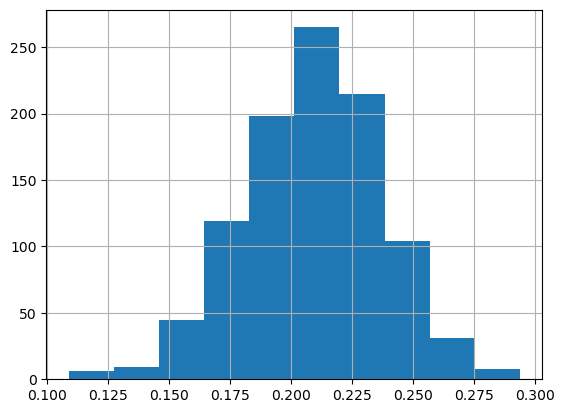

In [7]:
pd.Series(portfolio_values).hist();

#### 2. Basin-Level dependence
First, we start up by linking the asset locations to a specific basin. The geopandas package is used.

In [25]:
import geopandas as gpd
basins = gpd.read_file(hybas_basins)
print(basins.columns)
print(basins.size)
print(basins.head())
# print the values of JID column
print(basins["JID"].unique())

Index(['dtname', 'stname', 'stcode11', 'dtcode11', 'year_stat', 'Dist_LGD',
       'State_LGD', 'JID', 'geometry'],
      dtype='object')
108
          dtname            stname stcode11 dtcode11 year_stat  Dist_LGD  \
0  Lahul & Spiti  HIMACHAL PRADESH       02      025    2011_c      21.0   
1         Chamba  HIMACHAL PRADESH       02      023    2011_c      16.0   
2         Kangra  HIMACHAL PRADESH       02      024    2011_c      18.0   
3          Kullu  HIMACHAL PRADESH       02      026    2011_c      20.0   
4          Mandi  HIMACHAL PRADESH       02      027    2011_c      22.0   

   State_LGD  JID                                           geometry  
0        2.0  614  POLYGON ((76.79272 33.25664, 76.79396 33.25648...  
1        2.0  615  POLYGON ((76.56955 33.20975, 76.57211 33.20883...  
2        2.0  619  POLYGON ((76.90420 32.46746, 76.90506 32.46718...  
3        2.0  620  POLYGON ((77.15214 32.41457, 77.15272 32.41446...  
4        2.0  623  POLYGON ((76.80260 32.07037

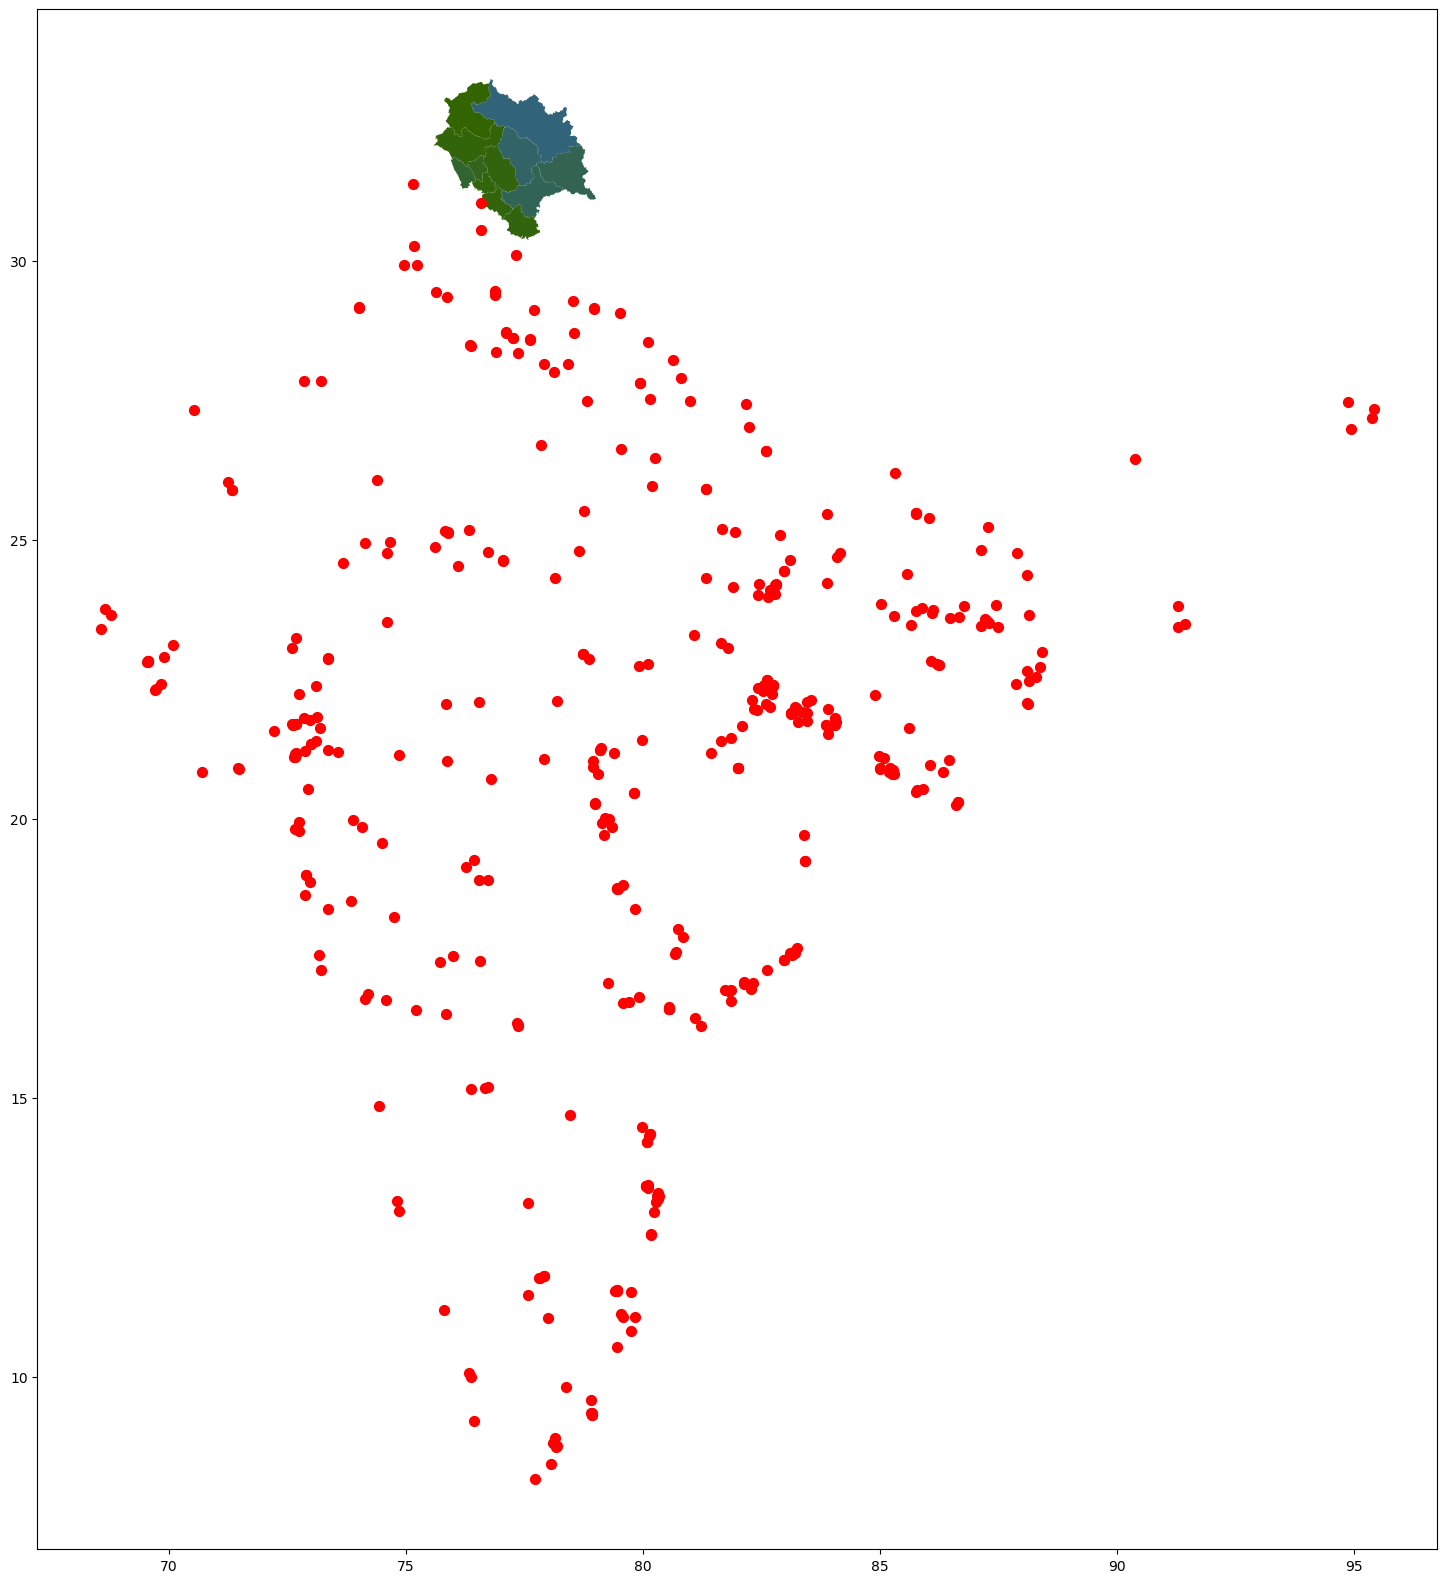

In [6]:
india, basins = link_basins(india, hybas_basins, visualize=True);

Once the basins are obtained, we simulate events at the basin level and incorporate it into the simulation:

In [10]:
def events_df(random_numbers, years=25):
    return_periods = [5, 10, 25, 50, 100, 200, 500, 1000]
    events = pd.DataFrame()
    for return_period in return_periods:
        simulated_data = random_numbers.sample(years).reset_index(drop=True)
        simulated_data = simulated_data.apply(lambda x: poisson.ppf(x, 1/return_period)).reset_index()
        simulated_data = simulated_data.replace(0, pd.NA).melt(id_vars="index").dropna()
        if simulated_data.empty:
            continue
        simulated_data.loc[:, "return_period"] = return_period
        events = pd.concat([events, simulated_data])
    events.columns = ["year", "basin", "events", "return_period"]
    events.basin = events.basin.astype(str)
    return events

Now we generate random portfolio values:

100%|██████████| 1000/1000 [12:30<00:00,  1.33it/s]


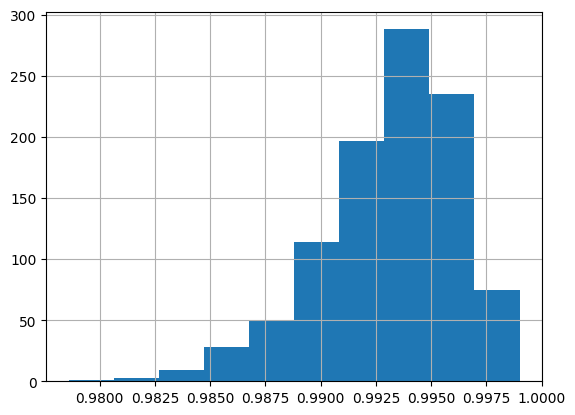

In [ ]:
np.random.seed(0)

portfolio_values_independent_basins = []
for i in tqdm(range(simulations)):
    events = events_df(uniform_random_numbers, years=25)
    assets = india.asset.to_list()
    insurer = Insurance("Insurance company", capital=insurer_capital)
    kernel = Kernel(assets=assets, insurers=[insurer])
    for asset in assets:
        if insured:
            asset.add_insurer(insurer)
        flood_basin = india[india.asset == asset].HYBAS_ID.iloc[0]
        events_asset = events[events.basin==flood_basin]
        CycloneBasinSim(asset, events_asset).simulate(kernel=kernel)
    kernel.run(time_horizon=25, verbose=0)
    portfolio_values_independent_basins.append(portfolio.underlying_value)
    for asset in assets:
        asset.reset()

pd.Series(portfolio_values_independent_basins).hist();

#### 3. Dependent Basins
In the previous simulation, the basins were assumed to be indepenent. Now, the dependencies between basins are taken into account using different copulas. We have a function to generate these events:

##### 3.1. Gaussian copula

100%|██████████| 1000/1000 [12:38<00:00,  1.32it/s]


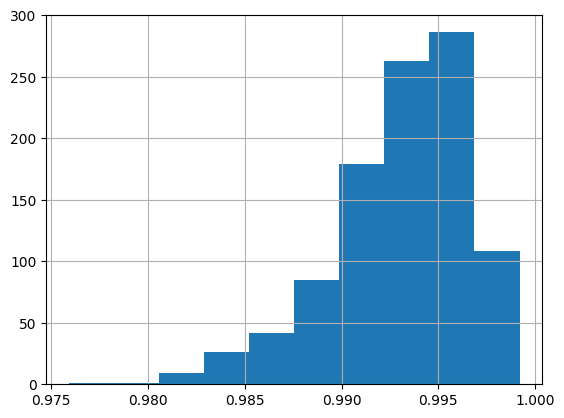

In [12]:
np.random.seed(0)

portfolio_values_gaussian_basins = []
for i in tqdm(range(simulations)):
    events = events_df(random_numbers=gaussian_random_numbers, years=25)
    assets = india.asset.to_list()
    insurer = Insurance("Insurance company", capital=insurer_capital)
    kernel = Kernel(assets=assets, insurers=[insurer])
    for asset in assets:
        if insured:
            asset.add_insurer(insurer)
        flood_basin = india[india.asset == asset].HYBAS_ID.iloc[0]
        events_asset = events[events.basin==flood_basin]
        FloodBasinSim(asset, events_asset).simulate(kernel=kernel)
    kernel.run(time_horizon=25, verbose=0)
    portfolio_values_gaussian_basins.append(portfolio.underlying_value)
    for asset in assets:
        asset.reset()
pd.Series(portfolio_values_gaussian_basins).hist();

##### 3.1. T-copula

100%|██████████| 1000/1000 [12:26<00:00,  1.34it/s]


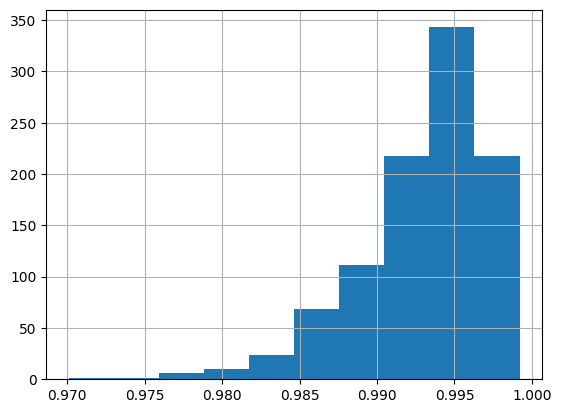

In [13]:
np.random.seed(0)

portfolio_values_t_basins = []
assets = india.asset.to_list()
for i in tqdm(range(simulations)):
    events = events_df(random_numbers=t_random_numbers, years=25)
    insurer = Insurance("Insurance company", capital=insurer_capital)
    kernel = Kernel(assets=assets, insurers=[insurer])
    for asset in assets:
        if insured:
            asset.add_insurer(insurer)
        flood_basin = india[india.asset == asset].HYBAS_ID.iloc[0]
        events_asset = events[events.basin==flood_basin]
        FloodBasinSim(asset, events_asset).simulate(kernel=kernel)
    kernel.run(time_horizon=25, verbose=0)
    portfolio_values_t_basins.append(portfolio.underlying_value)
    for asset in assets:
        asset.reset()

pd.Series(portfolio_values_t_basins).hist();

##### 3.3. Vine Copula

100%|██████████| 1000/1000 [12:23<00:00,  1.35it/s]


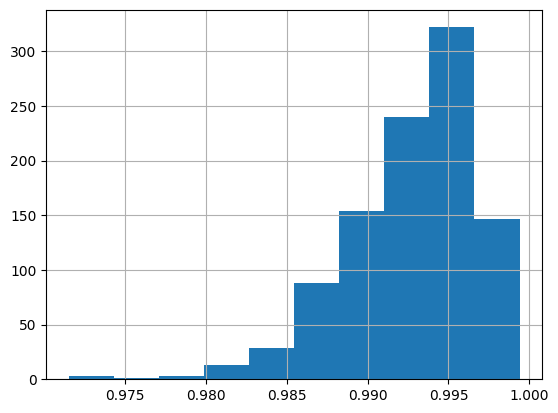

In [14]:
np.random.seed(0)

portfolio_values_vine_basins = []
assets = india.asset.to_list()
for i in tqdm(range(simulations)):
    events = events_df(random_numbers=vine_random_numbers, years=25)
    insurer = Insurance("Insurance company", capital=insurer_capital)
    kernel = Kernel(assets=assets, insurers=[insurer])
    for asset in assets:
        if insured:
            asset.add_insurer(insurer)
        flood_basin = india[india.asset == asset].HYBAS_ID.iloc[0]
        events_asset = events[events.basin==flood_basin]
        FloodBasinSim(asset, events_asset).simulate(kernel=kernel)
    kernel.run(time_horizon=25, verbose=0)
    portfolio_values_vine_basins.append(portfolio.underlying_value)
    for asset in assets:
        asset.reset()

pd.Series(portfolio_values_vine_basins).hist();

#### 4. Complete Dependence
In complete dependence, all assets are hit at the same time.

100%|██████████| 1000/1000 [12:24<00:00,  1.34it/s]


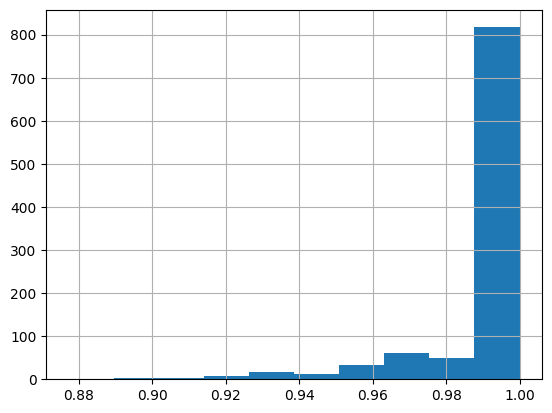

In [15]:
np.random.seed(0)

portfolio_values_complete_dependent_basins = []
assets = india.asset.to_list()
for i in tqdm(range(simulations)):
    events = events_df(random_numbers=complete_dependent_random_numbers, years=25)
    insurer = Insurance("Insurance company", capital=insurer_capital)
    kernel = Kernel(assets=assets, insurers=[insurer])
    for asset in assets:
        if insured:
            asset.add_insurer(insurer)
        flood_basin = india[india.asset == asset].HYBAS_ID.iloc[0]
        events_asset = events[events.basin==flood_basin]
        FloodBasinSim(asset, events_asset).simulate(kernel=kernel)
    kernel.run(time_horizon=25, verbose=0)
    portfolio_values_complete_dependent_basins.append(portfolio.underlying_value)
    for asset in assets:
        asset.reset()

pd.Series(portfolio_values_complete_dependent_basins).hist();


## Summary of results

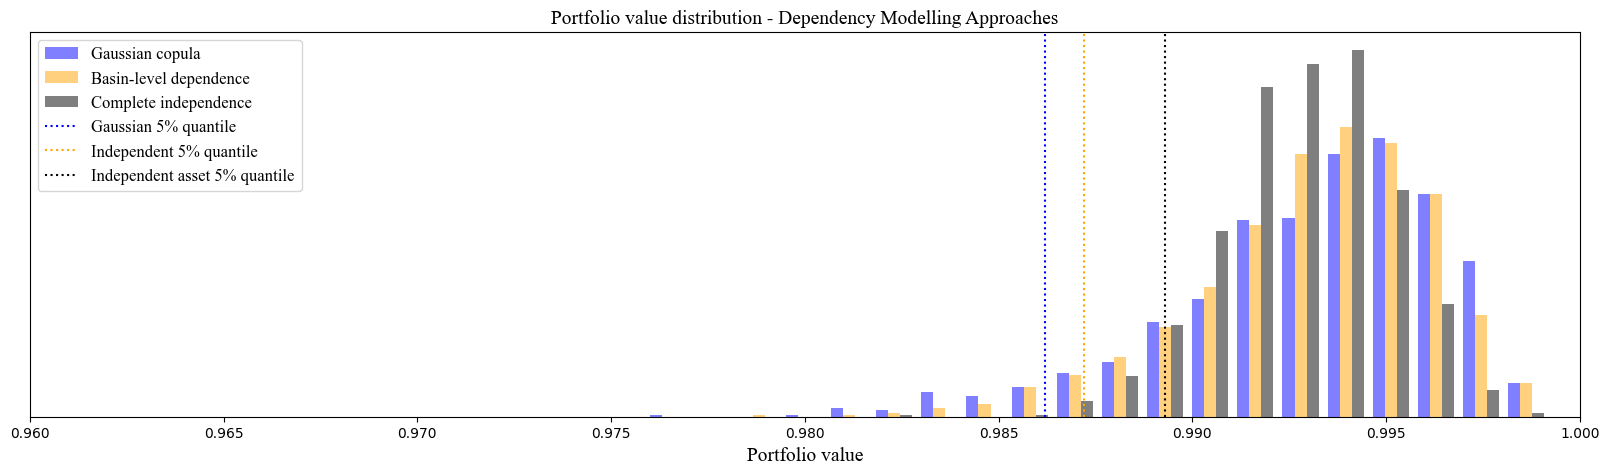

In [16]:
import matplotlib.font_manager as font_manager

font_man = font_manager.FontProperties(family='Times New Roman',
                                   style='normal', size=12)

asset_level = pd.Series(portfolio_values)
gaus = pd.Series(portfolio_values_gaussian_basins)
vine = pd.Series(portfolio_values_vine_basins)
independent = pd.Series(portfolio_values_independent_basins)
dependent = pd.Series(portfolio_values_complete_dependent_basins)
t_dist = pd.Series(portfolio_values_t_basins)
plt.figure(figsize=(20, 5))
plt.hist([gaus, independent, asset_level], bins=20,
         color=["blue", "orange", "black"],
         label=["Gaussian copula" , "Basin-level dependence", "Complete independence"], alpha=0.5, density=True)
gaus_q5 = gaus.quantile(0.05)
t_dist_q5 = t_dist.quantile(0.05)
vine_q5 = vine.quantile(0.05)
independent_q5 = independent.quantile(0.05)
asset_q5 = asset_level.quantile(0.05)
dependent_q5 = dependent.quantile(0.05)
gaus_q1 = gaus.quantile(0.01)
t_dist_q1 = t_dist.quantile(0.01)
vine_q1 = vine.quantile(0.01)
independent_q1 = independent.quantile(0.01)
asset_q1 = asset_level.quantile(0.01)
dependent_q1 = dependent.quantile(0.01)
gaus_mean = gaus.mean()
t_dist_mean = t_dist.mean()
vine_mean = vine.mean()
independent_mean = independent.mean()
asset_mean = asset_level.mean()
dependent_mean = dependent.mean()
font = {"size": 14, "name": "times new roman"}
plt.axvline(gaus_q5, color="blue", linestyle=":", label="Gaussian 5% quantile")
#plt.axvline(t_dist_q5, color="red", linestyle=":", label="T 5% quantile")
#plt.axvline(vine_q5, color="green", linestyle=":", label="Vine 5% quantile")
plt.axvline(independent_q5, color="orange", linestyle=":", label="Independent 5% quantile")
plt.axvline(asset_q5, color="black", linestyle=":", label="Independent asset 5% quantile")
#plt.axvline(dependent_q5, color="purple", linestyle=":", label="Complete dependent 5% quantile")
plt.xlabel("Portfolio value", fontdict=font)
plt.xlim(0.96, 1)
plt.title("Portfolio value distribution - Dependency Modelling Approaches", fontdict=font)
plt.legend(prop=font_man)
# Hide y-axis
plt.gca().axes.get_yaxis().set_visible(False)
#plt.savefig('portfolio_value_distribution_1.png', transparent=True)

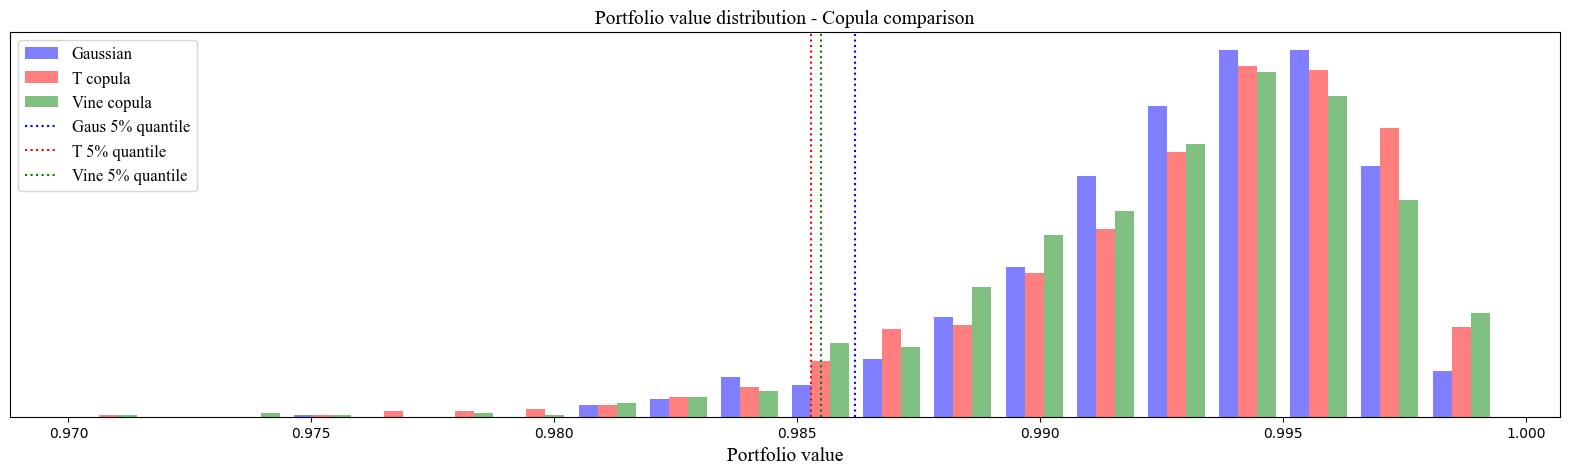

In [17]:
plt.figure(figsize=(20, 5))
plt.hist([gaus, t_dist, vine], bins=20,
         color=["blue", "red", "green"],
         label=["Gaussian" , "T copula", "Vine copula"], alpha=0.5, density=True)
font = {"size": 14, "name": "times new roman"}
plt.axvline(gaus_q5, color="blue", linestyle=":", label="Gaus 5% quantile")
plt.axvline(t_dist_q5, color="red", linestyle=":", label="T 5% quantile")
plt.axvline(vine_q5, color="green", linestyle=":", label="Vine 5% quantile")
#plt.axvline(independent_q5, color="yellow", linestyle=":", label="Independent 1% quantile")
#plt.axvline(asset_q5, color="blue", linestyle=":", label="Independent asset 1% quantile")
plt.xlabel("Portfolio value", fontdict=font)
#plt.xlim(0.96, 1)
plt.title("Portfolio value distribution - Copula comparison", fontdict=font)
plt.legend(prop=font_man)
plt.gca().axes.get_yaxis().set_visible(False)
#plt.savefig('portfolio_value_distribution.png', transparent=True)

Boxplots

/var/folders/zz/zvsv6f4s4wn29k9lt76bdlsr0000gn/T/ipykernel_42299/403043550.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().axes.set_xticklabels(["", "Complete Independence", "Basin-Level Independence", "Gaussian Copula", "T-Copula", "Vine Copula", "Complete dependence"], fontdict=font)


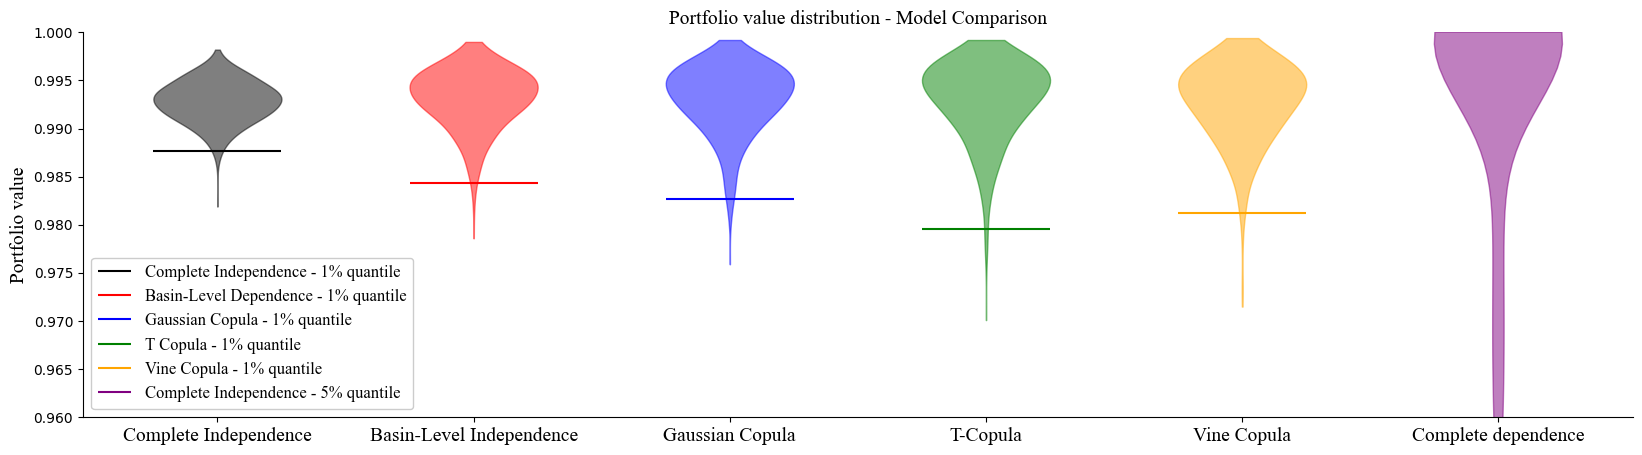

In [29]:
plt.figure(figsize=(20, 5))
vp = plt.violinplot(
    [asset_level, independent, gaus, t_dist, vine, dependent], 
    showmeans=False,
    showextrema=False,
    bw_method=0.4
    );
plt.hlines(asset_q1, 0.75, 1.25, color="black", label="Complete Independence - 1% quantile")
plt.hlines(independent_q1, 1.75, 2.25, color="red", label="Basin-Level Dependence - 1% quantile")
plt.hlines(gaus_q1, 2.75, 3.25, color="blue", label="Gaussian Copula - 1% quantile")
plt.hlines(t_dist_q1, 3.75, 4.25, color="green", label="T Copula - 1% quantile")
plt.hlines(vine_q1, 4.75, 5.25, color="orange", label="Vine Copula - 1% quantile")
plt.hlines(dependent_q1, 5.75, 6.25, color="purple",  label="Complete Independence - 5% quantile")
legend = plt.legend(loc="lower left", prop=font_man)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0.0))
colors = ["black", "red", "blue", "green", "orange", "purple"]
plt.ylabel("Portfolio value", fontdict=font)

for i, pc in enumerate(vp["bodies"]):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor(colors[i])
    pc.set_alpha(0.5)

plt.ylim(0.96, 1)
plt.gca().axes.set_xticklabels(["", "Complete Independence", "Basin-Level Independence", "Gaussian Copula", "T-Copula", "Vine Copula", "Complete dependence"], fontdict=font)
plt.title("Portfolio value distribution - Model Comparison", fontdict=font)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
#plt.savefig('portfolio_value_distribution_violin.png', transparent=True)


In [19]:
pd.DataFrame(
    {
        "Average Impact":   [asset_mean, independent_mean, gaus_mean, t_dist_mean, vine_mean, dependent_mean],
        "Median Impact":    [asset_level.median(), independent.median(), gaus.median(), t_dist.median(), vine.median(), dependent.median()],
        "Q10":              [asset_level.quantile(0.1), independent.quantile(0.1), gaus.quantile(0.1), t_dist.quantile(0.1), vine.quantile(0.1), dependent.quantile(0.1)],
        "Q5":               [asset_q5, independent_q5, gaus_q5, t_dist_q5, vine_q5, dependent_q5],
        "Q1":               [asset_q1, independent_q1, gaus_q1, t_dist_q1, vine_q1, dependent_q1]
    },
    index=["Complete Independence", "Basin-level independence", "Gaussian copula", "T copula", "Vine copula", "Complete dependence"]
)*100 - 100


,Average Impact,Median Impact,Q10,Q5,Q1
Complete Independence,-0.71892,-0.71,-0.991,-1.0700,-1.2501
Basin-level independence,-0.68722,-0.65,-1.110,-1.2800,-1.5800
Gaussian copula,-0.69320,-0.63,-1.150,-1.3805,-1.7202
T copula,-0.70209,-0.61,-1.280,-1.4705,-2.0803
Vine copula,-0.72826,-0.65,-1.260,-1.4500,-1.9000
Complete dependence,-0.76767,-0.10,-3.155,-4.3415,-7.5234


#### Bootstraps

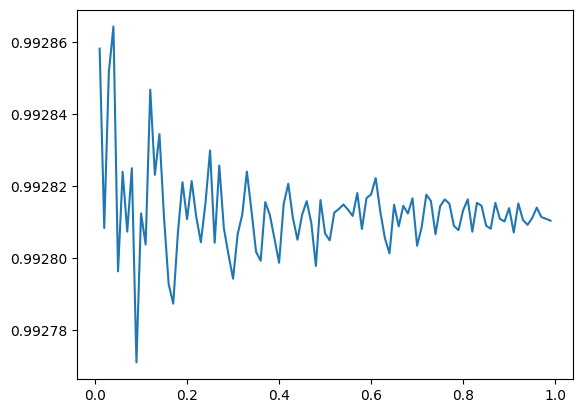

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# We will use subsampling without replacement to create the bootstrap distribution
# https://www.stat.berkeley.edu/~bickel/BS2008SS.pdf
# we try out bootstrapping for various values of m and check when the results are 
# stable
def get_bootstraps_m(data, m_values):
    means, variances = [], []
    for m in m_values:
        bootstrapped_means = []
        for i in range(100):
            sample = np.random.choice(data, size=int(len(t_dist)*m), replace=False)
            bootstrapped_means.append(sample.mean())
        means.append(np.mean(bootstrapped_means))
        variances.append(np.std(bootstrapped_means))
    return means, variances

def boostrap_q(data, q=0.95, m=0.6):
    bootstrapped_q = []
    for i in range(100):
        sample = np.random.choice(data, size=int(len(t_dist)*m), replace=False)
        bootstrapped_q.append(np.quantile(sample, q))
    return round(np.mean(bootstrapped_q), 6), round(np.quantile(bootstrapped_q, 0.05), 6), round(np.quantile(bootstrapped_q, 0.95),6)

m_values = np.arange(1, 100, 1)/100
means, variances = get_bootstraps_m(portfolio_values, m_values)
plt.plot(m_values, means); # Seems to become stable at 0.5 -> so we pick m equal to 0.75

/var/folders/zz/zvsv6f4s4wn29k9lt76bdlsr0000gn/T/ipykernel_42299/1534755473.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().axes.set_xticklabels(["", "Complete Independence", "Basin-Level Independence", "Gaussian Copula", "Vine Copula", "T-Copula", "Complete dependence"], fontdict=font)


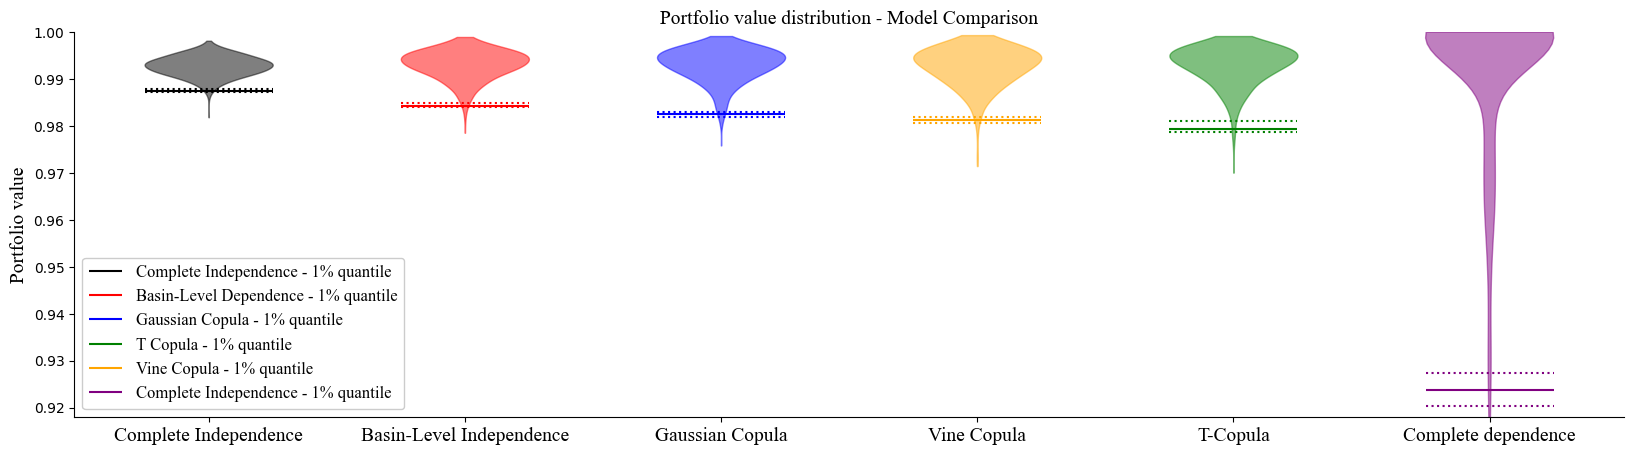

In [38]:
m=0.75
asset_q1, asset_lb, asset_up = boostrap_q(portfolio_values, q=0.01, m=m)
independent_q1, independent_lb, independent_up = boostrap_q(portfolio_values_independent_basins, q=0.01, m=m)
gaus_q1, gaus_lb, gaus_up = boostrap_q(portfolio_values_gaussian_basins, q=0.01, m=m)
t_dist_q1, t_dist_lb, t_dist_up = boostrap_q(portfolio_values_t_basins, q=0.01, m=m)
vine_q1, vine_lb, vine_up = boostrap_q(portfolio_values_vine_basins, q=0.01, m=m)
dependent_q1, dependent_lb, dependent_up = boostrap_q(portfolio_values_complete_dependent_basins, q=0.01, m=m)

asset_q5, asset_lb5, asset_up5 = boostrap_q(portfolio_values, q=0.05, m=m)
independent_q5, independent_lb5, independent_up5 = boostrap_q(portfolio_values_independent_basins, q=0.05, m=m)
gaus_q5, gaus_lb5, gaus_up5 = boostrap_q(portfolio_values_gaussian_basins, q=0.05, m=m)
t_dist_q5, t_dist_lb5, t_dist_up5 = boostrap_q(portfolio_values_t_basins, q=0.05, m=m)
vine_q5, vine_lb5, vine_up5 = boostrap_q(portfolio_values_vine_basins, q=0.05, m=m)
dependent_q5, dependent_lb5, dependent_up5 = boostrap_q(portfolio_values_complete_dependent_basins, q=0.05, m=m)

plt.figure(figsize=(20, 5))
vp = plt.violinplot(
    [asset_level, independent, gaus, vine, t_dist, dependent], 
    showmeans=False,
    showextrema=False,
    bw_method=0.4
    );
plt.hlines(asset_q1, 0.75, 1.25, color="black", label="Complete Independence - 1% quantile")
plt.hlines(independent_q1, 1.75, 2.25, color="red", label="Basin-Level Dependence - 1% quantile")
plt.hlines(gaus_q1, 2.75, 3.25, color="blue", label="Gaussian Copula - 1% quantile")
plt.hlines(t_dist_q1, 4.75, 5.25, color="green", label="T Copula - 1% quantile")
plt.hlines(vine_q1, 3.75, 4.25, color="orange", label="Vine Copula - 1% quantile")
plt.hlines(dependent_q1, 5.75, 6.25, color="purple",  label="Complete Independence - 1% quantile")
plt.hlines(asset_lb, 0.75, 1.25, color="black", linestyle=":")
plt.hlines(independent_lb, 1.75, 2.25, color="red", linestyle=":")
plt.hlines(gaus_lb, 2.75, 3.25, color="blue", linestyle=":")
plt.hlines(t_dist_lb, 4.75, 5.25, color="green", linestyle=":")
plt.hlines(vine_lb, 3.75, 4.25, color="orange", linestyle=":")
plt.hlines(dependent_lb, 5.75, 6.25, color="purple", linestyle=":")
plt.hlines(asset_up, 0.75, 1.25, color="black", linestyle=":")
plt.hlines(independent_up, 1.75, 2.25, color="red", linestyle=":")
plt.hlines(gaus_up, 2.75, 3.25, color="blue", linestyle=":")
plt.hlines(t_dist_up, 4.75, 5.25, color="green", linestyle=":")
plt.hlines(vine_up, 3.75, 4.25, color="orange", linestyle=":")
plt.hlines(dependent_up, 5.75, 6.25, color="purple", linestyle=":")

legend = plt.legend(loc="lower left", prop=font_man)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0.0))
colors = ["black", "red", "blue", "orange","green", "purple"]
plt.ylabel("Portfolio value", fontdict=font)

for i, pc in enumerate(vp["bodies"]):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor(colors[i])
    pc.set_alpha(0.5)
plt.ylim(0.918, 1)

plt.gca().axes.set_xticklabels(["", "Complete Independence", "Basin-Level Independence", "Gaussian Copula", "Vine Copula", "T-Copula", "Complete dependence"], fontdict=font)
plt.title("Portfolio value distribution - Model Comparison", fontdict=font)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.savefig('portfolio_value_distribution_violin_no_insurance.png', transparent=True, bbox_inches='tight')

In [22]:
table = pd.DataFrame(
    {
        "Average Impact":   [asset_mean, independent_mean, gaus_mean, t_dist_mean, vine_mean, dependent_mean],
        "Median Impact":    [asset_level.median(), independent.median(), gaus.median(), t_dist.median(), vine.median(), dependent.median()],
        "Q5":               [asset_q5, independent_q5, gaus_q5, t_dist_q5, vine_q5, dependent_q5],
        "Q1":               [asset_q1, independent_q1, gaus_q1, t_dist_q1, vine_q1, dependent_q1],
    },
    index=["Complete Independence", "Basin-level independence", "Gaussian copula", "T copula", "Vine copula", "Complete dependence"]
)
table = (table-1)*100
table.loc[:, "Q5 Interval"] = [f"[{round((asset_up5-1)*100, 2)}, {round((asset_lb5-1)*100, 2)}]",
                               f"[{round((independent_up5-1)*100, 2)}, {round((independent_lb5-1)*100, 2)}]",
                               f"[{round((gaus_up5-1)*100, 2)}, {round((gaus_lb5-1)*100, 2)}]",
                               f"[{round((t_dist_up5-1)*100, 2)}, {round((t_dist_lb5-1)*100, 2)}]",
                               f"[{round((vine_up5-1)*100, 2)}, {round((vine_lb5-1)*100, 2)}]",
                               f"[{round((dependent_up5-1)*100, 2)}, {round((dependent_lb5-1)*100, 2)}]"]
table.loc[:, "Q1 Interval"] = [f"[{round((asset_up-1)*100, 2)}, {round((asset_lb-1)*100, 2)}]",
                               f"[{round((independent_up-1)*100, 2)}, {round((independent_lb-1)*100, 2)}]",
                               f"[{round((gaus_up-1)*100, 2)}, {round((gaus_lb-1)*100, 2)}]",
                               f"[{round((t_dist_up-1)*100, 2)}, {round((t_dist_lb-1)*100, 2)}]",
                               f"[{round((vine_up-1)*100, 2)}, {round((vine_lb-1)*100, 2)}]",
                               f"[{round((dependent_up-1)*100, 2)}, {round((dependent_lb-1)*100, 2)}]"]
table

,Average Impact,Median Impact,Q5,Q1,Q5 Interval,Q1 Interval
Complete Independence,-0.71892,-0.71,-1.0748,-1.2415,"[-1.06, -1.1]","[-1.21, -1.27]"
Basin-level independence,-0.68722,-0.65,-1.2788,-1.5634,"[-1.25, -1.31]","[-1.51, -1.6]"
Gaussian copula,-0.69320,-0.63,-1.3935,-1.7286,"[-1.36, -1.44]","[-1.69, -1.8]"
T copula,-0.70209,-0.61,-1.4806,-2.0628,"[-1.47, -1.52]","[-1.92, -2.12]"
Vine copula,-0.72826,-0.65,-1.4506,-1.8807,"[-1.44, -1.47]","[-1.82, -1.93]"
Complete dependence,-0.76767,-0.10,-4.3651,-7.5755,"[-4.09, -4.68]","[-7.17, -7.92]"
